In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import AnovaRM
import pandas as pd
import os
import warnings
import json
import pingouin as pg
warnings.filterwarnings('ignore')

In [2]:
# data directory, day 1
data_dir = '../data/day1'
# find all csv files in the data directory
all_files = os.listdir(data_dir)
# filter out the csv files
participant_files = [f for f in all_files if f.endswith('.csv')]
# Path to all participant files
participant_files = [data_dir + '/' + f for f in participant_files]


In [3]:
participant_ids = []
for file_path in participant_files:
    # Extract participant ID
    participant_id = file_path.split('_')[0].split('/')[-1]
    # save the participant ID to the list
    participant_ids.append(participant_id)

In [4]:
# Add MemoryType and CueCondition columns based on shapeTruth and available cue information
def classify_memory_and_cue(row, wm_values, ltm_values):
    try:
        shape_truth_value = int(row['shapeTruth'])
    except ValueError:
        # If conversion fails, default to a placeholder that won't match WM or LTM values
        shape_truth_value = -1
    # Determine if the item is WM or LTM based on shapeTruth
    memory_type = 'WM' if shape_truth_value in wm_values else 'LTM' if shape_truth_value in ltm_values else 'Unknown'
    cue_condition = 'Neutral' if row['cueLoc'] == 'neutral' else 'Informative' if row['cueLoc'] in ['wm1', 'wm2', 'ltm1', 'ltm2'] else 'Unknown'
    return pd.Series([memory_type, cue_condition], index=['MemoryType', 'CueCondition'])

# Function to calculate error and RT for bins
def calculate_metrics(trials, error_col, rt_col):
    bins_metrics = trials.groupby('bin').agg(
        error=('rawColorDeviation' if error_col == 'rawColorDeviation' else 'rawShapeDeviation', lambda x: np.mean(np.abs(x))),
        rt=(rt_col, 'mean')
    ).reset_index()
    return bins_metrics

In [5]:
WM_LTM_VALUES = [89, 179, 269, 359]
color_wm = np.array([65, 143, 111]) / 255
color_ltm = np.array([138, 118, 190]) / 255

In [6]:
# Process each file to analyze learning trials
learning_results = []
sexes = []
ages = []
handednesses = []
# Analyze learning trials
for file_path in participant_files:
    df = pd.read_csv(file_path)
    
    # Extract participant ID
    participant_id = file_path.split('_')[0].split('/')[-1]

    # Learning trials start after this row
    learning_start_idx = df[df['LearnStart.stopped'].notna()].index.max() + 1
    learning_trials = df.iloc[learning_start_idx:].reset_index(drop=True)
    
    # extract demographic information: sex, age, handedness, which is a unique identifier for each participant
    sex = learning_trials['Sex (female/male)'].iloc[0]
    age = learning_trials['Age'].iloc[0]
    handedness = learning_trials['Handedness (left/right)'].iloc[0]

    # Separate color and shape trials
    color_trials = learning_trials[learning_trials['probeType'] == 'color']
    shape_trials = learning_trials[learning_trials['probeType'] == 'shape']
    
    # Bin trials into * bins for each type
    color_trials['bin'] = pd.qcut(color_trials.index, 4, labels=range(1, 5))
    shape_trials['bin'] = pd.qcut(shape_trials.index, 4, labels=range(1, 5))
    
    # Calculate metrics for color and shape trials
    color_metrics = calculate_metrics(color_trials, 'rawColorDeviation', 'LearnColorMouse.time')
    shape_metrics = calculate_metrics(shape_trials, 'rawShapeDeviation', 'LearnShapeMouse.time')
    
    # Add participant ID and trial type to metrics
    color_metrics['participant_id'] = participant_id
    color_metrics['trial_type'] = 'color'
    shape_metrics['participant_id'] = participant_id
    shape_metrics['trial_type'] = 'shape'
    
    # Append results
    learning_results.append(color_metrics)
    learning_results.append(shape_metrics)

    # Append demographic information
    sexes.append(sex)
    ages.append(age)
    handednesses.append(handedness)
    
# Combine all results into a single DataFrame
all_learning_results = pd.concat(learning_results, ignore_index=True)



In [7]:
# get the summary of demographic information: how many 'female' and 'male' in sexes, average age, and number of people with different handedness
print(sexes)
print(ages)
print(handednesses)

# for sexes, unify the capitalization to lowercase, and count the number of 'female' and 'male'
male_count = 0
female_count = 0
for sex in sexes:
    sex = sex.lower()
    if sex == 'male':
        male_count += 1
    else:
        female_count += 1

# calculate the average age and standard deviation
average_age = np.nanmean(ages)
std_age = np.nanstd(ages)

# count the number of people with different handedness
left_count = 0
right_count = 0
other_count = 0
for handedness in handednesses:
    handedness = handedness.lower()
    handedness = handedness.strip()
    if handedness == 'left' or handedness == 'left-handed':
        left_count += 1
    elif handedness == 'right' or handedness == 'right-handed':
        right_count += 1
    else:
        other_count += 1
        print('Unknown handedness: ', handedness)

print('Number of male: ',male_count)
print('Number of female: ', female_count)
print('Average age: ', average_age)
print('Standard deviation of age: ', std_age)
print('Number of left-handed: ', left_count)
print('Number of right-handed: ', right_count)
print('Number of other handedness: ', other_count)

['Male', 'Male', 'Male', 'female', 'male', 'male', 'female', 'male', 'male', 'male', 'female', 'Female', 'male', 'female', 'male', 'Male', 'male', 'Female', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'female', 'male', 'female', 'Male', 'Male', 'male', 'male', 'male', 'male', 'female', 'male', 'female', 'male', 'male', 'FEMALE', 'Male', 'male', 'male', 'Female', 'male', 'male', 'female', 'female', 'Male', 'female', 'Male', 'male', 'Male', 'male', 'female', 'male', 'Male', 'female', 'female', 'Female', 'male', 'female', 'Male', 'Female', 'female', 'male', 'Male', 'Male', 'female', 'female', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'Male', 'male', 'male', 'Male', 'male', 'male', 'male', 'male', 'female', 'Male', 'male', 'female', 'male', 'male', 'Female', 'male', 'female', 'male', 'male', 'female', 'male', 'male', 'male', 'female', 'Male', 'male', 'male', 'male', 'Female', 'male', 'male', 'female', 'male', 'male', 'male',

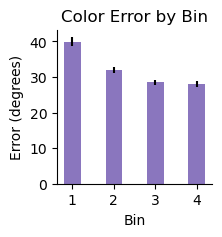

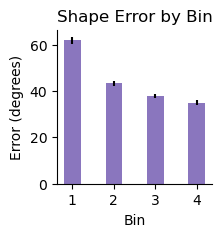

In [8]:
# Group-level analysis: Calculate the average error and RT for each bin across all participants
group_avg_color_acc = all_learning_results[all_learning_results['trial_type'] == 'color'].groupby('bin')['error'].mean().reset_index()
group_avg_shape_acc = all_learning_results[all_learning_results['trial_type'] == 'shape'].groupby('bin')['error'].mean().reset_index()
group_avg_color_rt = all_learning_results[all_learning_results['trial_type'] == 'color'].groupby('bin')['rt'].mean().reset_index()
group_avg_shape_rt = all_learning_results[all_learning_results['trial_type'] == 'shape'].groupby('bin')['rt'].mean().reset_index()

# Calculate within-participant averages
avg_color_acc = all_learning_results[all_learning_results['trial_type'] == 'color'].groupby(['participant_id', 'bin'])['error'].mean().reset_index()
avg_shape_acc = all_learning_results[all_learning_results['trial_type'] == 'shape'].groupby(['participant_id', 'bin'])['error'].mean().reset_index()
avg_color_rt = all_learning_results[all_learning_results['trial_type'] == 'color'].groupby(['participant_id', 'bin'])['rt'].mean().reset_index()
avg_shape_rt = all_learning_results[all_learning_results['trial_type'] == 'shape'].groupby(['participant_id', 'bin'])['rt'].mean().reset_index()

bins = range(1, 5)
x = np.arange(len(bins))  # the label locations
width = 0.4  # the width of the bars
color_ltm = np.array([138, 118, 190]) / 255

# plot the average error for color trials, with corrected standard error bars
fig, ax = plt.subplots(figsize=(2, 2))
rects1 = ax.bar(x, group_avg_color_acc['error'], width, label='Color', color=color_ltm)
# create pivot table of the color accuracy data, with participant_id as index and bin as columns
color_acc_pivot = avg_color_acc.pivot_table(index='participant_id', columns='bin', values='error')
# Calculate grand mean, subject means, and normalized data
grand_mean = color_acc_pivot.mean().mean()
subject_means = color_acc_pivot.mean(axis=1)
normalized_data = color_acc_pivot.subtract(subject_means, axis=0).add(grand_mean, axis=0)
# Calculate standard error and correction factor
se = normalized_data.sem()
n_subjects = len(color_acc_pivot)
correction_factor = np.sqrt(n_subjects / (n_subjects - 1))
corrected_se_color = se * correction_factor
# add error bars
ax.errorbar(x, group_avg_color_acc['error'], yerr=corrected_se_color, fmt='none', ecolor='black', capsize=0)
ax.set_ylabel('Error (degrees)')
ax.set_xlabel('Bin')
ax.set_xticks(x)
ax.set_xticklabels(bins)
# remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('Color Error by Bin')
plt.show()

# plot the average error for shape trials, with corrected standard error bars
fig, ax = plt.subplots(figsize=(2, 2))
rects1 = ax.bar(x, group_avg_shape_acc['error'], width, label='Shape', color=color_ltm)
# create pivot table of the shape accuracy data, with participant_id as index and bin as columns
shape_acc_pivot = avg_shape_acc.pivot_table(index='participant_id', columns='bin', values='error')
# Calculate grand mean, subject means, and normalized data
grand_mean = shape_acc_pivot.mean().mean()
subject_means = shape_acc_pivot.mean(axis=1)
normalized_data = shape_acc_pivot.subtract(subject_means, axis=0).add(grand_mean, axis=0)
# Calculate standard error and correction factor
se = normalized_data.sem()
n_subjects = len(shape_acc_pivot)
correction_factor = np.sqrt(n_subjects / (n_subjects - 1))
corrected_se_shape = se * correction_factor
# add error bars
ax.errorbar(x, group_avg_shape_acc['error'], yerr=corrected_se_shape, fmt='none', ecolor='black', capsize=0)
ax.set_ylabel('Error (degrees)')
ax.set_xlabel('Bin')
ax.set_xticks(x)
ax.set_xticklabels(bins)
# remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('Shape Error by Bin')
plt.show()

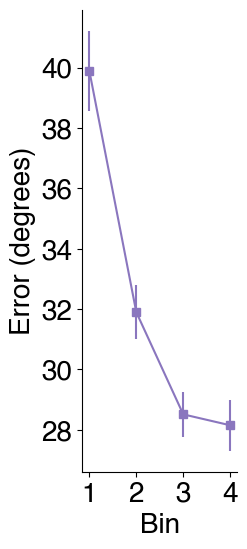

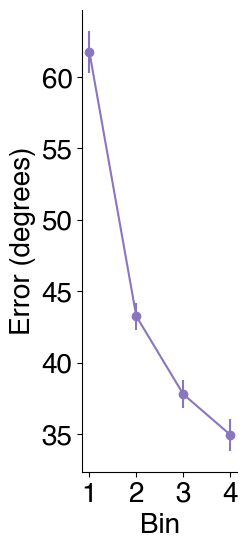

In [9]:
# instead of bar plots, we can also use line plots to show the trend of the data
fig, ax = plt.subplots(figsize=(2, 6))
ax.plot(group_avg_color_acc['error'], label='Color', color=color_ltm, marker='s', markersize=6)
# add error bars
ax.errorbar(x, group_avg_color_acc['error'], yerr=corrected_se_color, fmt='none', ecolor=color_ltm, capsize=0)
ax.set_ylabel('Error (degrees)')
ax.set_xlabel('Bin')
ax.set_xticks(x)
ax.set_xticklabels(bins)
# ax.set_ylim(0, 45)
# set y ticks to be integers
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
# remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.set_title('Color learning over trials')
# change the axes font to Helvetica and set the font size to 25
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontname('Helvetica')
    item.set_fontsize(20)
plt.show()

fig, ax = plt.subplots(figsize=(2, 6))
ax.plot(group_avg_shape_acc['error'], label='Shape', color=color_ltm, marker='o', markersize=6)
# add error bars
ax.errorbar(x, group_avg_shape_acc['error'], yerr=corrected_se_shape, fmt='none', ecolor=color_ltm, capsize=0)
ax.set_ylabel('Error (degrees)')
ax.set_xlabel('Bin')
ax.set_xticks(x)
ax.set_xticklabels(bins)
# remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.set_title('Shape learning over trials')
# ax.set_ylim(20, 70)
# change the axes font to Helvetica and set the font size to 25
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontname('Helvetica')
    item.set_fontsize(20)
plt.show()

In [10]:
# perform a repeated measures ANOVA on the color accuracy data, using the statsmodels AnovaRM class

# set up the repeated measures model
color_acc_model = AnovaRM(data=avg_color_acc, depvar='error', subject='participant_id', within=['bin'])
color_acc_fit = color_acc_model.fit()
# print the ANOVA table
print(color_acc_fit)
# do the same using the pingouin package
color_acc_rm = pg.rm_anova(data=avg_color_acc, dv='error', within='bin', subject='participant_id',effsize="np2")

# perform a repeated measures ANOVA on the shape accuracy data, using the statsmodels AnovaRM class

# set up the repeated measures model
shape_acc_model = AnovaRM(data=avg_shape_acc, depvar='error', subject='participant_id', within=['bin'])
shape_acc_fit = shape_acc_model.fit()
# print the ANOVA table
print(shape_acc_fit)
# do the same using the pingouin package
shape_acc_rm = pg.rm_anova(data=avg_shape_acc, dv='error', within='bin', subject='participant_id',effsize="np2")


              Anova
    F Value Num DF  Den DF  Pr > F
----------------------------------
bin 23.4993 3.0000 354.0000 0.0000

              Anova
    F Value Num DF  Den DF  Pr > F
----------------------------------
bin 83.9959 3.0000 354.0000 0.0000



In [15]:
avg_color_acc.columns

Index(['participant_id', 'bin', 'error'], dtype='object')

In [19]:
# Perform one-way repeated-measures ANOVA for color accuracy data
data_melted1 = avg_color_acc
# Contrast weights for bins: [-3, -1, 1, 3]
weights = np.array([-3, -1, 1, 3])
data_melted1['weights'] = data_melted1['bin'].replace({'1': -3, '2': -1, '3': 1, '4': 3})

# Fit the model
model = ols('error ~ weights', data=data_melted1).fit()
anova_table = sm.stats.anova_lm(model, typ=1)

# Calculate partial eta squared for the linear model
ss_effect = anova_table.loc['weights', 'sum_sq']
ss_residual = anova_table.loc['Residual', 'sum_sq']

partial_eta_squared = ss_effect / (ss_effect + ss_residual)

# Add partial eta squared to the ANOVA table
anova_table['Partial Eta Squared'] = [partial_eta_squared, np.nan]

anova_table

,df,sum_sq,mean_sq,F,PR(>F),Partial Eta Squared
weights,3.0,10637.034370,3545.678123,9.015166,0.000008,0.054194
Residual,472.0,185638.294118,393.301471,NaN,NaN,NaN


In [20]:
# Perform one-way repeated-measures ANOVA for shape accuracy data
data_melted2 = avg_shape_acc
# Contrast weights for bins: [-3, -1, 1, 3]
weights = np.array([-3, -1, 1, 3])
data_melted2['weights'] = data_melted2['bin'].replace({'1': -3, '2': -1, '3': 1, '4': 3})

# Fit the model
model = ols('error ~ weights', data=data_melted2).fit()
anova_table = sm.stats.anova_lm(model, typ=1)

# Calculate partial eta squared for the linear model
ss_effect = anova_table.loc['weights', 'sum_sq']
ss_residual = anova_table.loc['Residual', 'sum_sq']

partial_eta_squared = ss_effect / (ss_effect + ss_residual)

# Add partial eta squared to the ANOVA table
anova_table['Partial Eta Squared'] = [partial_eta_squared, np.nan]

anova_table

,df,sum_sq,mean_sq,F,PR(>F),Partial Eta Squared
weights,3.0,51812.842521,17270.947507,38.469732,2.952887e-22,0.196472
Residual,472.0,211903.926218,448.948996,NaN,NaN,NaN


In [11]:
# data directory
data_dir = '../data/day2'
# find all csv files in the data directory
all_files = os.listdir(data_dir)
# filter out the csv files
participant_files = [f for f in all_files if f.endswith('.csv')]
# Path to all participant files
participant_files = [data_dir + '/' + f for f in participant_files]

all_test_data = pd.DataFrame()
# Analyze testing trials
for file_path in participant_files:
    
    # Extract participant ID
    participant_id = file_path.split('_')[0].split('/')[-1]
    
    data = pd.read_csv(file_path)
    ltm_values = data[['trueMemory1', 'trueMemory2']].dropna().astype(int).values.flatten().tolist()
    wm_values = [value for value in WM_LTM_VALUES if value not in ltm_values]
    test_trial_start_index = data['PracBlockEnd.stopped'].first_valid_index() + 1
    test_trials = data.iloc[test_trial_start_index:]
    test_trials['ParticipantID'] = participant_id  # Add participant identifier
    memory_trials = test_trials[test_trials['taskType'] == 'memory']
    memory_trials['ltm_shapes'] = [ltm_values for _ in range(len(memory_trials))]
    memory_trials['wm_shapes'] = [wm_values for _ in range(len(memory_trials))]
    memory_trials[['MemoryType', 'CueCondition']] = memory_trials.apply(
        lambda row: classify_memory_and_cue(row, wm_values,ltm_values), axis=1)

    test_data = memory_trials[['ParticipantID', 'mouseTime', 'shapeTruth', 'selectedShape', 'deviation', 'rawDeviation', 'MemoryType', 'CueCondition', 'ltm_shapes', 'wm_shapes']]
    all_test_data = pd.concat([all_test_data, test_data])

all_test_data['deviation'] = all_test_data['deviation'].astype(float)


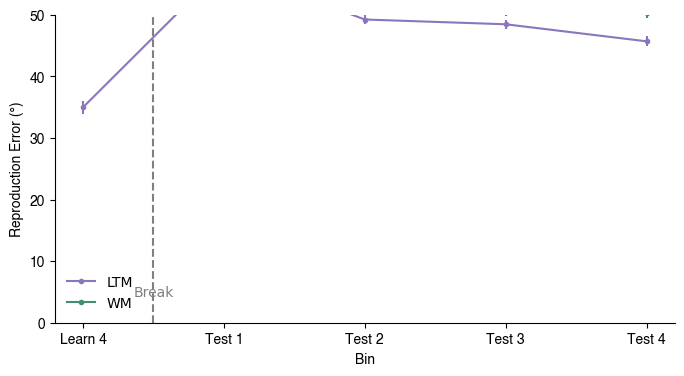

In [12]:
# for each participant, split LTM and WM testing trials into 4 bins, and calculate their average LTM and WM location reproduction accuracy in each bin
# and plot them along with the 4 bins for location trials in the learning phase
ltm_data = all_test_data[all_test_data['MemoryType'] == 'LTM']
wm_data = all_test_data[all_test_data['MemoryType'] == 'WM']
mean_ltm_bin_accuracy = []
mean_wm_bin_accuracy = []
# group ltm_data by participants, and then for each participant split LTM testing trials into 4 bins
for participant_id in all_test_data['ParticipantID'].unique():
    sub_ltm_data = ltm_data[ltm_data['ParticipantID'] == participant_id].reset_index(drop=False)
    sub_wm_data = wm_data[wm_data['ParticipantID'] == participant_id].reset_index(drop=False)
    n_test_bins = 4
    n_ltm_trials = len(sub_ltm_data)
    n_wm_trials = len(sub_wm_data)
    ltm_bin_size = n_ltm_trials / n_test_bins
    wm_bin_size = n_wm_trials / n_test_bins
    ltm_bin_accuracy = []
    wm_bin_accuracy = []
    for i in range(n_test_bins):
        ltm_start = int(i * ltm_bin_size)
        ltm_end = int((i + 1) * ltm_bin_size)
        wm_start = int(i * wm_bin_size)
        wm_end = int((i + 1) * wm_bin_size)
        ltm_bin_accuracy.append(np.mean(sub_ltm_data['deviation'].iloc[ltm_start:ltm_end]))
        wm_bin_accuracy.append(np.mean(sub_wm_data['deviation'].iloc[wm_start:wm_end]))
    mean_ltm_bin_accuracy.append(ltm_bin_accuracy)
    mean_wm_bin_accuracy.append(wm_bin_accuracy)

# Calculate group-level averages
group_ltm_bin_accuracy = np.mean(mean_ltm_bin_accuracy, axis=0)
group_wm_bin_accuracy = np.mean(mean_wm_bin_accuracy, axis=0)

# Plot learning curve (line plot) + ltm acc for shape trials, with error bars
x = np.arange(1 + n_test_bins)
testing_bins = range(1, n_test_bins + 1)
# calculate corrected standard error
grand_mean_ltm = np.mean(group_ltm_bin_accuracy)
grand_mean_wm = np.mean(group_wm_bin_accuracy)
subject_means_ltm = np.mean(mean_ltm_bin_accuracy, axis=1)
subject_means_wm = np.mean(mean_wm_bin_accuracy, axis=1)
normalized_data_ltm = mean_ltm_bin_accuracy - subject_means_ltm[:, np.newaxis] + grand_mean_ltm
normalized_data_wm = mean_wm_bin_accuracy - subject_means_wm[:, np.newaxis] + grand_mean_wm
se_ltm = np.std(normalized_data_ltm, axis=0) / np.sqrt(len(mean_ltm_bin_accuracy))
se_wm = np.std(normalized_data_wm, axis=0) / np.sqrt(len(mean_wm_bin_accuracy))
correction_factor = np.sqrt(len(mean_ltm_bin_accuracy) / (len(mean_ltm_bin_accuracy) - 1))
corrected_se_ltm = se_ltm * correction_factor
corrected_se_wm = se_wm * correction_factor

# plot the last learning bin + 4 testing bins: concatenate group_shape_bin_accuracy with group_ltm_bin_accuracy
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot([group_avg_shape_acc.iloc[-1]['error']] + list(group_ltm_bin_accuracy), label='LTM', color=color_ltm, marker='o', markersize=3)
# add error bars
ax.errorbar(x, [group_avg_shape_acc.iloc[-1]['error']] + list(group_ltm_bin_accuracy), yerr=[corrected_se_shape.tolist()[-1]] + list(corrected_se_ltm), fmt='none', ecolor=color_ltm, capsize=0)
# plot 4 WM bins alone
ax.plot(range(1,5), group_wm_bin_accuracy, label='WM', color=color_wm, marker='o', markersize=3)
# add error bars
ax.errorbar(range(1,5), group_wm_bin_accuracy, yerr=corrected_se_wm, fmt='none', ecolor=color_wm, capsize=0)
ax.set_ylabel('Reproduction Error (°)')
ax.set_xlabel('Bin')
ax.set_xticks(x)
ax.set_xticklabels(['Learn 4'] + [f'Test {i}' for i in testing_bins])
# # set y ticks to have 2 decimal places
# ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.2f}'.format(x)))
# remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# set y axis limits
ax.set_ylim([0, 50])
# add legend, removing the frame
ax.legend(frameon=False)
# draw a vertical line to separate learning and testing, and add a label: "break"
ax.axvline(0.5, color='gray', linestyle='--')
ax.text(0.5, 5, 'Break', ha='center', va='center', color='gray')

# change the axes font to Helvetica and set the font size to 25
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontname('Helvetica')
    item.set_fontsize(10)

plt.show()




